In [1]:
!pip install efficientnet -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout,LSTM,TimeDistributed, MaxPooling2D,Conv2D, 
                                    GlobalAveragePooling2D, Flatten)
#from skimage.restoration import denoise_wavelet
#from skimage import exposure
from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.applications.resnet50 import ResNet50
#import pydicom
#from pydicom.pixel_data_handlers.util import apply_voi_lut
#from skimage.transform import resize
import glob
import os
from tqdm import tqdm
import imageio
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from efficientnet.tfkeras import EfficientNetB1#, EfficientNetB2, EfficientNetB0
from sklearn.preprocessing import OneHotEncoder
from PIL import Image
import cv2
from sklearn.model_selection import StratifiedKFold

In [3]:
#t2w_model_files = sorted(glob.glob('../input/t2w-models-trained-on-cropped-images/*'))
#t2w_model_files

In [4]:
'''for i in tqdm(t2w_model_files):
    model = load_model(i)
    fname = 'Weights_' + i.split('/')[-1]
    model.save_weights(fname)'''

"for i in tqdm(t2w_model_files):\n    model = load_model(i)\n    fname = 'Weights_' + i.split('/')[-1]\n    model.save_weights(fname)"

In [5]:
IMG_SIZE = 224
N_SEQUENCES = 20

In [6]:
train_labels = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
train_labels['PatientIDs'] = ['{0:05d}'.format(x) for x in train_labels['BraTS21ID']]
train_labels.head()

,BraTS21ID,MGMT_value,PatientIDs
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006


In [7]:
X = train_labels['PatientIDs']
Y = train_labels['MGMT_value']

In [8]:
#ohe = OneHotEncoder()
#Y = ohe.fit_transform(Y.values.reshape(-1,1)).toarray()

In [9]:
no_image = np.zeros((IMG_SIZE, IMG_SIZE))
imageio.imwrite('./No_image.png', no_image)

In [10]:
def select_images(images, n_images_to_consider=20):
    '''Selects the given number of images to consider'''
    no_image_path = './No_image.png'
    images_path_100 = []
    n_images = len(images)
    #new_paths_100 = []
    
    if n_images < n_images_to_consider:
        while n_images < n_images_to_consider:
            images.append(no_image_path)
            n_images += 1
        new_paths_100 = images.copy()
        
    elif n_images == n_images_to_consider:
        new_paths_100 = images.copy()
    else:
        m = n_images - n_images_to_consider
        if m % 2 == 0:
            left = right = int(m/2)
        else:
            left = int(m//2)
            right = int(left + 1)
        
        right = n_images - right
        new_paths_100 = images[left:right]
    
    return new_paths_100

In [33]:
t2w_cases = dict() # images

for c in tqdm(X.values):
    temp = sorted(glob.glob('../input/rsna-data-set-preprocessed-with-30-imgs-each/train/' + c + '/T1w/*'), 
              key = lambda l: int(l.split('-')[-1].split('.')[-2]))
    
    c_t2w_images = select_images(temp, N_SEQUENCES)
    t2w_cases[c] = c_t2w_images

100%|██████████| 585/585 [00:09<00:00, 62.13it/s]


In [12]:
t2w_cases['00000']

['../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-190.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-191.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-192.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-193.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-194.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-195.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-196.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-197.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-198.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-199.png',
 '../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-200.png',
 '../input/rsna-data-set-preproc

In [13]:
#X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, stratify = Y, random_state=42)
#X_train.shape, X_val.shape

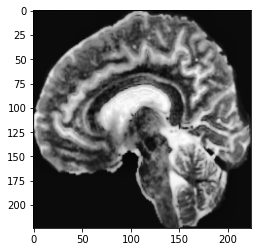

In [14]:
img = plt.imread('../input/rsna-data-set-preprocessed-with-30-imgs-each/train/00000/T2w/Image-209.png')
plt.imshow(img)

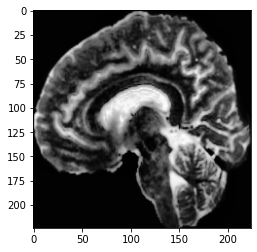

In [15]:
plt.imshow(tf.image.adjust_gamma(img, 1.5))

In [16]:
def generator(x, y, batch_size=4, n_sequences = 20):
    
    AUTO = tf.data.experimental.AUTOTUNE
    
    def apply_clahe(img):
        hsv = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2HSV)
        hsv_planes = cv2.split(hsv)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
        hsv_planes[2] = clahe.apply(hsv_planes[2])
        hsv = cv2.merge(hsv_planes)
        hsv = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        
        return hsv
    
    def augmentations(img):
        img = tf.image.adjust_brightness(img, 0.2)
        img = tf.image.adjust_gamma(img, 1.5)
        img = tf.image.flip_left_right(img)
        
        return img
    
    def load_image(x):
    
        file = tf.io.read_file(x)
        img = tf.image.decode_png(file, channels = 3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        #img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))   

        return img

    def load_image_stream(x, y):

        image_sequence = np.zeros((n_sequences, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
        img_path_lst = t2w_cases[x.decode('utf-8')]
        #img_path_lst = t2w_cases[x]
        c = 0
        for p in img_path_lst:
            img = load_image(p)
            #img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
            #img = apply_clahe(img)/255.0
            #image_sequence[c] = np.resize(img, (IMG_SIZE, IMG_SIZE, 3))
            image_sequence[c] = augmentations(img)
            c += 1
        return image_sequence.astype(np.float32), y
    
    dset = tf.data.Dataset.from_tensor_slices((x,y))
    dset = dset.shuffle(buffer_size = 500)
    dset = dset.map(lambda x1, y1: tf.numpy_function(load_image_stream, [x1,y1], [tf.float32, tf.float32]),
                    num_parallel_calls = AUTO)
   # dset = dset.map(augmentations, num_parallel_calls = AUTO)
    dset = dset.repeat()
    dset = dset.batch(batch_size)
    dset = dset.prefetch(buffer_size = AUTO)
    
    return dset

In [29]:
#temp = generator(X, Y.values.astype(np.float32))

In [30]:
#for i,j in temp:
#    print(i.shape, j.shape)
#    break

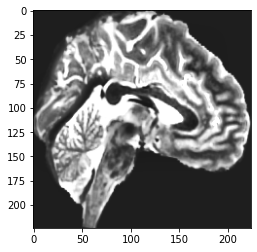

In [38]:
#plt.imshow(i[0][3])

In [ ]:
def B1_Model():
    input_ = Input(shape = (N_SEQUENCES, IMG_SIZE, IMG_SIZE, 3))

    b0 = TimeDistributed(EfficientNetB1(include_top=False, weights='imagenet'))(input_)
    print(b0.shape)
    b0 = TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())(b0)
    x = LSTM(256, activation='relu', return_sequences=False)(b0)
    x = Dense(1024, activation='relu', kernel_initializer = tf.keras.initializers.he_normal(seed=42))(x)
    print('Dense LSTM: ', x.shape)

    b0_flatten = Flatten()(b0)
    print(b0_flatten.shape)
    x_b0 = Dense(1024, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal(seed=421))(b0_flatten)
    print('Dense Res: ', x_b0.shape)

    x = tf.keras.layers.Add()([x, x_b0])
    x = Dense(512, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal(seed=123))(x)
    x = Dense(2, activation='softmax')(x)
    print(x.shape)
    model_b1 = Model(input_, x)
    
    #weights_file = './Weights_T2w_base_model_with_Res_b1_Preprocessed_' + str(split) + '_epoch_10.h5'
    #print('Loading ',weights_file)
    #model_b2.load_weights(weights_file)
    
    return model_b1#, weights_file

In [34]:
BATCH_SIZE = 4
split = 0
skf = StratifiedKFold(7, random_state=42, shuffle=True)
for train_idx, cv_idx in skf.split(X, Y):
    if split < 5:
        print('\n SPLIT: ', split)

        X_train = X.iloc[train_idx]
        X_cv = X.iloc[cv_idx]
        y_train = Y.iloc[train_idx]
        y_cv = Y.iloc[cv_idx]

        ohe = OneHotEncoder()
        y = ohe.fit(y_train.values.reshape(-1,1))
        y_train = ohe.transform(y_train.values.reshape(-1,1)).toarray()
        y_cv = ohe.transform(y_cv.values.reshape(-1,1)).toarray()
        
        train_gen = generator(X_train, y_train.astype(np.float32), BATCH_SIZE, N_SEQUENCES)
        val_gen = generator(X_cv, y_cv.astype(np.float32), BATCH_SIZE, N_SEQUENCES)

        def schedule(epoch, lr):
            
            if epoch >= 3 and epoch < 7:
                new_lr = lr * 0.6
            else:
                new_lr = lr * 0.3

            return new_lr

        #callbacks
        lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)
        #filepath = './T1wce_base_model_with_Res_b1_prepocessed{}.h5'.format(split)
        #checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

       # model_b1 = B1_Model()
        model_to_load = '../input/t1w-ensemble-models5-on-cropped-data/T1w_base_model_with_Res_b1_Preprocessed_{}_epoch_10.h5'.format(split)
        print('Loading: ', model_to_load)
        model_b1 = tf.keras.models.load_model(model_to_load)
        LR = 0.0001
        initializer = tf.keras.optimizers.Adam(lr = LR)
        model_b1.compile(initializer, 'categorical_crossentropy')

        train_steps = (X_train.shape[0] // BATCH_SIZE) + 1
        val_steps = (X_cv.shape[0] // BATCH_SIZE) + 1

        # with preprocessing
        hist = model_b1.fit(train_gen, epochs = 10, steps_per_epoch=train_steps,
                          validation_data=val_gen, validation_steps=val_steps,
                          callbacks=[lr_scheduler], verbose=1)
        new_filepath = './T1w_T2w_with_20_224_Res_B1_Preprocessed_{}_epoch_10.h5'.format(split)
        tf.keras.models.save_model(model_b1, new_filepath)

    split += 1


 SPLIT:  0


In [ ]:
from IPython.display import FileLink
from shutil import make_archive

In [ ]:
make_archive('FLAIR split weights', 'zip', './')
FileLink(r'./FLAIR split 2 weights.zip')

In [ ]:
# completed

In [ ]:
#model_trials = tf.keras.models.load_model('./T2w_base_model_with_Res_b0_11.h5')

In [35]:
def generator_inference(x, batch_size=8, n_sequences = 50):
    
    AUTO = tf.data.experimental.AUTOTUNE
    
    def apply_clahe(img):
        hsv = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2HSV)
        hsv_planes = cv2.split(hsv)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
        hsv_planes[2] = clahe.apply(hsv_planes[2])
        hsv = cv2.merge(hsv_planes)
        hsv = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        
        return hsv
    
    def load_image(x):
    
        file = tf.io.read_file(x)
        img = tf.image.decode_png(file, channels = 3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        #img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))   

        return img

    def load_image_stream(x):

        image_sequence = np.zeros((n_sequences, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
        img_path_lst = t2w_cases[x.decode('utf-8')]
        #img_path_lst = t2w_cases[x]
        c = 0
        for p in img_path_lst:
            img = cv2.imread(p)
            img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
            #img = apply_clahe(img)/255.0
            #image_sequence[c] = np.resize(img, (IMG_SIZE, IMG_SIZE, 3))
            image_sequence[c] = img
            c += 1
        return image_sequence.astype(np.float32)
    
    dset = tf.data.Dataset.from_tensor_slices((x))
    dset = dset.map(lambda x1: tf.numpy_function(load_image_stream, [x1], [tf.float32]), num_parallel_calls = AUTO)
    #dset = dset.batch(batch_size)
    dset = dset.prefetch(buffer_size = AUTO)
    
    return dset

In [36]:
test_gen = generator_inference(X_cv.values, batch_size=1, n_sequences=N_SEQUENCES)

In [ ]:
#for i in test_gen:
#    print(i[0].shape)#, j.shape)
#    break#

# T1w

In [37]:
# on t2w images
# 2 -> 0.474
# 4 -> 0.572
# 0 -> 0.514
# 1 -> 0.525
# 3 -> 0.455

In [ ]:
# on t1w images
# 2 -> 0.522
# 4 -> 0.550
# 0 -> 0.537
# 1 -> 0.547
# 3 -> 0.505

In [46]:
model_b1 = tf.keras.models.load_model('./T1w_T2w_with_20_224_Res_B1_Preprocessed_2_epoch_10.h5')

In [47]:
#train
pred_25 = model_b1.predict(test_gen, verbose=1)
roc_auc_score(y_cv, pred_25)

84/84 [==============================] - 7s 53ms/step


0.5227272727272727

In [22]:
pred_25

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [ ]:

model2 = tf.keras.models.load_model('./T2w_base_model_with_Res_b1_Preprocessed_1_epoch_10.h5')
model3 = tf.keras.models.load_model('./T2w_base_model_with_Res_b1_Preprocessed_2_epoch_10.h5')
model4 = tf.keras.models.load_model('./T2w_base_model_with_Res_b1_Preprocessed_3_epoch_10.h5')
model5 = tf.keras.models.load_model('./T2w_base_model_with_Res_b1_Preprocessed_4_epoch_10.h5')

In [ ]:
pred1 = model1.predict(test_gen)
pred2 = model2.predict(test_gen)
pred3 = model3.predict(test_gen)
pred4 = model4.predict(test_gen)
pred5 = model5.predict(test_gen)

In [ ]:
pred1.shape

In [ ]:
combined_preds = (pred1[:,1] + pred2[:,1] + pred3[:,1] + pred4[:,1] + pred5[:,1])/5

In [ ]:
roc_auc_score(y_cv[:,1], combined_preds)